In [34]:
#Imports
import pandas as pd
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import UnigramTagger,pos_tag
from nltk import bigrams, ngrams

In [97]:
#Useful functions for what is coming next
def list_counter(lst):
    serie = pd.Series(lst)
    return serie.value_counts()

def tokenize(x):
    return word_tokenize(x)
    
def frequency_list(lst):
    counts = list_counter(lst)
    total = len(lst)
    freq = np.array(counts) / total
    freg = freq * 100
    return pd.Series(freg.round(2), counts.index)

In [11]:
#Reading the dataset (only 500k rows for complexity purposes)
#df=pd.read_csv(f"C:/Users/mehdi/Downloads/en.openfoodfacts.org.products.csv",sep='\t',encoding='UTF-8', nrows=500000)

In [14]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1656948610,2022-07-04T15:30:10Z,1656948613,2022-07-04T15:30:13Z,Andrè,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1656488106,2022-06-29T07:35:06Z,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1654250311,2022-06-03T09:58:31Z,1654270474,2022-06-03T15:34:34Z,Skyr,NaN,NaN,...,NaN,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploration and cleaning of the data

In [15]:
col_names=[]
for x in df.columns:
    col_names.append(x)
index=0
for i in (df.loc[6]):
    print(str(col_names[index])+" : "+str(i))
    index+=1

code : 000000000003327986
url : http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado
creator : kiliweb
created_t : 1574175736
created_datetime : 2019-11-19T15:02:16Z
last_modified_t : 1624390765
last_modified_datetime : 2021-06-22T19:39:25Z
product_name : Filetes de pollo empanado
abbreviated_product_name : nan
generic_name : nan
quantity : nan
packaging : nan
packaging_tags : nan
packaging_en : nan
packaging_text : nan
brands : nan
brands_tags : nan
categories : nan
categories_tags : nan
categories_en : nan
origins : nan
origins_tags : nan
origins_en : nan
manufacturing_places : nan
manufacturing_places_tags : nan
labels : nan
labels_tags : nan
labels_en : nan
emb_codes : nan
emb_codes_tags : nan
first_packaging_code_geo : nan
cities : nan
cities_tags : nan
purchase_places : nan
stores : nan
countries : Espagne
countries_tags : en:spain
countries_en : Spain
ingredients_text : nan
ingredients_tags : nan
ingredients_analysis_tags : nan
allergens : nan
a

In [16]:
id_cols = ['code','product_name']

In [17]:
for i in range(len(df.columns)) :
    print(df.dtypes.index[i], ' : ', df.dtypes[i])

code  :  object
url  :  object
creator  :  object
created_t  :  int64
created_datetime  :  object
last_modified_t  :  int64
last_modified_datetime  :  object
product_name  :  object
abbreviated_product_name  :  object
generic_name  :  object
quantity  :  object
packaging  :  object
packaging_tags  :  object
packaging_en  :  object
packaging_text  :  object
brands  :  object
brands_tags  :  object
categories  :  object
categories_tags  :  object
categories_en  :  object
origins  :  object
origins_tags  :  object
origins_en  :  object
manufacturing_places  :  object
manufacturing_places_tags  :  object
labels  :  object
labels_tags  :  object
labels_en  :  object
emb_codes  :  object
emb_codes_tags  :  object
first_packaging_code_geo  :  object
cities  :  float64
cities_tags  :  object
purchase_places  :  object
stores  :  object
countries  :  object
countries_tags  :  object
countries_en  :  object
ingredients_text  :  object
ingredients_tags  :  object
ingredients_analysis_tags  :  obj

### Nutrition

In [23]:
#Let's look at the nutrition cols (they have _100g in their name) and keep only the cols that have less than 50% of Null values
all_nutrition_cols = [x for x in col_names if '_100g' in x]
print('Pourcentage de valeurs Null par colonnes :\n')

i=0
nutrition_cols_to_keep = []
for col in all_nutrition_cols:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    if res < 50:
        nutrition_cols_to_keep.append(col)
        i += 1
        print(f'   - {col} : {res}%')
        
print("\nNombre de colonnes à garder: " , i)
print(nutrition_cols_to_keep)

Pourcentage de valeurs Null par colonnes :

   - energy-kcal_100g : 13.65%
   - energy_100g : 13.42%
   - fat_100g : 13.66%
   - saturated-fat_100g : 18.38%
   - carbohydrates_100g : 13.69%
   - sugars_100g : 15.33%
   - fiber_100g : 43.93%
   - proteins_100g : 13.65%
   - salt_100g : 19.43%
   - sodium_100g : 19.43%

Nombre de colonnes à garder:  10
['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


### Categories

In [26]:
[x for x in df.columns if 'catego' in x]

['categories',
 'categories_tags',
 'categories_en',
 'main_category',
 'main_category_en']

In [27]:
categories_col = ['categories', 'categories_tags', 'categories_en','main_category','main_category_en']
print('Pourcentage de valeurs Null par colonnes :\n')

for col in categories_col:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')

Pourcentage de valeurs Null par colonnes :

   - categories : 49.41%
   - categories_tags : 49.41%
   - categories_en : 49.41%
   - main_category : 49.41%
   - main_category_en : 49.41%


In [29]:
main_catego_df=df['main_category_en'].dropna()
main_catego_df

3                    Cream cheeses
10                       Groceries
18           Squeezed apple juices
19                    Almond paste
20         Seasoned grated carrots
                    ...           
499973             Protein powders
499974             Protein powders
499989             Protein powders
499990    Bodybuilding supplements
499991                        BCAA
Name: main_category_en, Length: 252935, dtype: object

In [32]:
#Let's do some treatment on the cateogries
text=main_catego_df.tolist()
text = ' '.join(text).lower()
text=text.replace('fr:','')
lemmatizer = WordNetLemmatizer()
result=word_tokenize(text)
result=[lemmatizer.lemmatize(word) for word in result]
result=' '.join(result).lower()

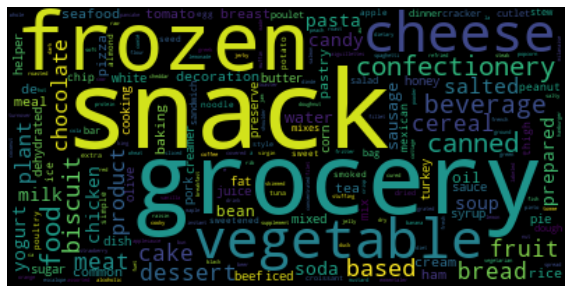

In [36]:
#Let's do a small wordcloud to visualize the results
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=False).generate(res)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### Ingredients

In [37]:
#Let's do the same for ingredients
ingredients_col = ['ingredients_text']
print('Pourcentage de valeurs Null par colonnes :\n')

for col in ingredients_col:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')

Pourcentage de valeurs Null par colonnes :

   - ingredients_text : 51.39%


In [41]:
#Let's now chose the cols we want to finally keep (we put the nutrition cols at the end for readability purposes)
cols_to_keep = id_cols + categories_col + ingredients_col + nutrition_cols_to_keep
print('Pourcentage de valeurs Null par colonnes :\n')
for col in cols_to_keep:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')

Pourcentage de valeurs Null par colonnes :

   - code : 0.0%
   - product_name : 1.93%
   - categories : 49.41%
   - categories_tags : 49.41%
   - categories_en : 49.41%
   - main_category : 49.41%
   - main_category_en : 49.41%
   - ingredients_text : 51.39%
   - energy-kcal_100g : 13.65%
   - energy_100g : 13.42%
   - fat_100g : 13.66%
   - saturated-fat_100g : 18.38%
   - carbohydrates_100g : 13.69%
   - sugars_100g : 15.33%
   - fiber_100g : 43.93%
   - proteins_100g : 13.65%
   - salt_100g : 19.43%
   - sodium_100g : 19.43%


In [43]:
final_df = df[cols_to_keep]
final_df.head()

,code,product_name,categories,categories_tags,categories_en,main_category,main_category_en,ingredients_text,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,00000000000000225,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,Andrè,NaN,NaN,NaN,NaN,NaN,NaN,165.0,690.0,2.0,2.00,65.0,12.6,3.0,1.5,NaN,NaN
2,00000000000003429145,L.casei,NaN,NaN,NaN,NaN,NaN,"Leche semidesnatada, azucar 6.9%, leche desnat...",NaN,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.10,0.040
3,00000000000026772226,Skyr,"Produits laitiers, Desserts, Produits fermenté...","en:dairies,en:desserts,en:fermented-foods,en:f...","Dairies,Desserts,Fermented foods,Fermented mil...",en:cream-cheeses,Cream cheeses,NaN,57.0,238.0,0.2,0.10,3.9,3.9,NaN,10.0,0.09,0.036
4,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,0.560


In [75]:
df_ingr = final_df[['ingredients_text']]
df_ingr = df_ingr[~df_ingr['ingredients_text'].isnull()]
df_ingr['ingredients_text'] = df_ingr['ingredients_text'].astype('str')


2         [Leche semidesnatada,  azucar 6.9%,  leche des...
9         [beta alanine,  creatine hcl,  ancient peat & ...
10        [eau graines de téguments de moutarde vinaigre...
28        [antioxydant : érythorbate de sodium,  coloran...
36        [Lait entier,  sucre,  amidon de maïs,  cacao,...
                                ...                        
499950    [Isolat de protéine de lactosérum (émulsifiant...
499951    [peux contenir des traces d'oeuf,  de noix,  d...
499957    [Concentré de protéines de lactosérum,  concen...
499989    [Beta-alanine,  1-arginine,  I-citrulline,  ma...
499993    [Isolat de protéine de lactosérum (émulsifiant...
Name: ingredients_text, Length: 243051, dtype: object

In [76]:
df_ingr['ingredients_text']

2         Leche semidesnatada, azucar 6.9%, leche desnat...
9         beta alanine, creatine hcl, ancient peat & app...
10        eau graines de téguments de moutarde vinaigre ...
28        antioxydant : érythorbate de sodium, colorant ...
36        Lait entier, sucre, amidon de maïs, cacao, Aga...
                                ...                        
499950    Isolat de protéine de lactosérum (émulsifiant ...
499951    peux contenir des traces d'oeuf, de noix, de b...
499957    Concentré de protéines de lactosérum, concentr...
499989    Beta-alanine, 1-arginine, I-citrulline, malate...
499993    Isolat de protéine de lactosérum (émulsifiant ...
Name: ingredients_text, Length: 243051, dtype: object

In [108]:
#Let's tokenize the ingredients (applying the function to the whole DF seems to cause problems such as tokens being
#the whole row instead of each component)
tokenised_ingr=[]
for i in range(len(df_ingr)):
    token_temp=tokenize(df_ingr['ingredients_text'].iloc[i])
    for j in range(len(token_temp)):
        tokenised_ingr.append(token_temp[j])

In [110]:
tokenised_ingr = [str(x).lower() for x in tokenised_ingr]

In [111]:
len(tokenised_ingr)

14157014

In [112]:
print(tokenised_ingr[0])

leche


In [113]:
tokenised_without_specials = [x for x in tokenised_ingr if re.match('[a-zA-Z]+',str(x))]
len(tokenised_without_specials)

8870722

In [115]:
lemmetized_tokens = [lemmatizer.lemmatize(str(word)) for word in tokenised_without_specials]

In [193]:
print(f"""
Tous les tokens : {len(tokenised_ingr)}

Tokens sans charactères spéciaux : {len(tokenised_without_specials)}""")


Tous les tokens : 14157014

Tokens sans charactères spéciaux : 8870722


In [120]:
#Let's explore these tokens
counts_tokenised_1gram = list_counter(lemmetized_tokens)
freq_tokenised_1gram = frequency_list(lemmetized_tokens)
for i in range(10000, 300000, 20000):
    res = sum(counts_tokenised_1gram > i)
    print(f"Nombre d'éléments cités plus de {i} fois : {res}\n")

Nombre d'éléments cités plus de 10000 fois : 170

Nombre d'éléments cités plus de 30000 fois : 71

Nombre d'éléments cités plus de 50000 fois : 34

Nombre d'éléments cités plus de 70000 fois : 22

Nombre d'éléments cités plus de 90000 fois : 13

Nombre d'éléments cités plus de 110000 fois : 12

Nombre d'éléments cités plus de 130000 fois : 9

Nombre d'éléments cités plus de 150000 fois : 4

Nombre d'éléments cités plus de 170000 fois : 4

Nombre d'éléments cités plus de 190000 fois : 1

Nombre d'éléments cités plus de 210000 fois : 1

Nombre d'éléments cités plus de 230000 fois : 1

Nombre d'éléments cités plus de 250000 fois : 0

Nombre d'éléments cités plus de 270000 fois : 0

Nombre d'éléments cités plus de 290000 fois : 0



In [119]:
for i in np.arange(0.2, 4, 0.2):
    i = round(i,1)
    res = sum(freq_tokenised_1gram > i)
    print(f"Nombre d'éléments ayant une fréquence supérieur à {i}% : {res}\n")

Nombre d'éléments ayant une fréquence supérieur à 0.2% : 108

Nombre d'éléments ayant une fréquence supérieur à 0.4% : 60

Nombre d'éléments ayant une fréquence supérieur à 0.6% : 29

Nombre d'éléments ayant une fréquence supérieur à 0.8% : 22

Nombre d'éléments ayant une fréquence supérieur à 1.0% : 13

Nombre d'éléments ayant une fréquence supérieur à 1.2% : 13

Nombre d'éléments ayant une fréquence supérieur à 1.4% : 11

Nombre d'éléments ayant une fréquence supérieur à 1.6% : 7

Nombre d'éléments ayant une fréquence supérieur à 1.8% : 4

Nombre d'éléments ayant une fréquence supérieur à 2.0% : 3

Nombre d'éléments ayant une fréquence supérieur à 2.2% : 1

Nombre d'éléments ayant une fréquence supérieur à 2.4% : 1

Nombre d'éléments ayant une fréquence supérieur à 2.6% : 1

Nombre d'éléments ayant une fréquence supérieur à 2.8% : 0

Nombre d'éléments ayant une fréquence supérieur à 3.0% : 0

Nombre d'éléments ayant une fréquence supérieur à 3.2% : 0

Nombre d'éléments ayant une fréq

In [121]:
top100_ingr = list(counts_tokenised_1gram.index[:100])
print('Les 100 éléments les plus cités :\n\n')

i = 0
res = ''
for el in top100_ingr : 
    i+=1
    res = res + el + '   '
    if i%10 == 0:
        print(res, '\n')
        res =''

Les 100 éléments les plus cités :


salt   acid   oil   sugar   and   water   corn   flavor   flour   milk    

natural   sodium   wheat   of   organic   syrup   vitamin   gum   soy   color    

starch   powder   citric   contains   cheese   le   soybean   de   artificial   lecithin    

spice   calcium   garlic   juice   phosphate   a   onion   red   palm   enzyme    

or   modified   yellow   extract   riboflavin   folic   potassium   pepper   concentrate   iron    

mononitrate   vegetable   niacin   vinegar   yeast   tomato   enriched   preservative   cocoa   whey    

with   culture   dextrose   cream   canola   butter   pasteurized   whole   chocolate   to    

reduced   egg   than   maltodextrin   protein   xanthan   rice   and/or   sunflower   thiamine    

fructose   blue   high   dried   sea   bean   mono   disodium   diglycerides   caramel    

white   nonfat   paprika   c   chicken   peanut   thiamin   food   the   sorbate    



In [133]:
#We can see stopwords in the top100 (like "and"), let's get rid of them and of "and/or" which is not part of the stopwords dict
all_stopwords = stopwords.words()
top_ingr=[x for x in top100_ingr if x not in all_stopwords and x!="and/or"]
print("We are now left with " + str(len(top_ingr)) + " ingredients")

We are now left with 85 ingredients


In [134]:
i = 0
res = ''
for el in top_ingr : 
    i+=1
    res = res + el + '   '
    if i%10 == 0:
        print(res, '\n')
        res =''

salt   acid   oil   sugar   water   corn   flavor   flour   milk   natural    

sodium   wheat   organic   syrup   vitamin   gum   color   starch   powder   citric    

contains   cheese   soybean   artificial   lecithin   spice   calcium   garlic   juice   phosphate    

onion   red   palm   enzyme   modified   yellow   extract   riboflavin   folic   potassium    

pepper   concentrate   iron   mononitrate   vegetable   niacin   vinegar   yeast   tomato   enriched    

preservative   cocoa   whey   culture   dextrose   cream   canola   butter   pasteurized   chocolate    

reduced   egg   maltodextrin   protein   xanthan   rice   sunflower   thiamine   fructose   blue    

high   dried   bean   mono   disodium   diglycerides   caramel   white   nonfat   paprika    



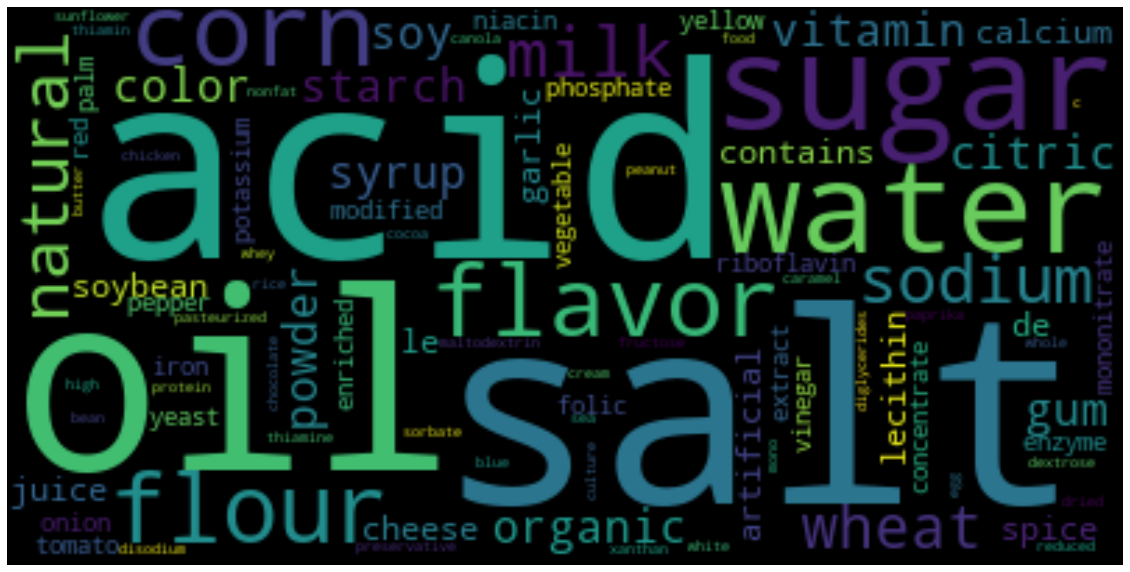

In [136]:
res=' '.join(top100_ingr).lower()
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=False).generate(res)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### Bigrams

In [141]:
#We can notice the presence of bigrams (words that go together), let's tokenize them and explore
bigrams_ingr = [' '.join(x) for x in bigrams(tokenised_without_specials) if isinstance(x[0],str) and isinstance(x[1],str)]
counts_tokenised_2gram = list_counter(bigrams_ingr)
freq_tokenised_2gram = frequency_list(bigrams_ingr)
for i in range(10000, 250000, 20000):
    res = sum(counts_tokenised_2gram > i)
    print(f"Nombre d'éléments cités plus de {i} fois : {res}\n")

Nombre d'éléments cités plus de 10000 fois : 97

Nombre d'éléments cités plus de 30000 fois : 11

Nombre d'éléments cités plus de 50000 fois : 3

Nombre d'éléments cités plus de 70000 fois : 0

Nombre d'éléments cités plus de 90000 fois : 0

Nombre d'éléments cités plus de 110000 fois : 0

Nombre d'éléments cités plus de 130000 fois : 0

Nombre d'éléments cités plus de 150000 fois : 0

Nombre d'éléments cités plus de 170000 fois : 0

Nombre d'éléments cités plus de 190000 fois : 0

Nombre d'éléments cités plus de 210000 fois : 0

Nombre d'éléments cités plus de 230000 fois : 0



In [142]:
top100_ingr_2gram = list(counts_tokenised_2gram.index[:100])
print('Les 100 bigrams les plus cités :\n\n')

i = 0
res = ''
for el in top100_ingr_2gram : 
    i+=1
    res = res + el + '   '
    if i%10 == 0:
        print(res, '\n')
        res =''

Les 100 bigrams les plus cités :


wheat flour   citric acid   corn syrup   soy lecithin   folic acid   natural flavor   soybean oil   corn starch   or less   less of    

riboflavin folic   mononitrate riboflavin   flour niacin   contains or   less than   reduced iron   salt enzymes   artificial flavor   natural flavors   and artificial    

xanthan gum   natural and   palm oil   flour wheat   thiamine mononitrate   sea salt   than of   canola oil   vegetable oil   niacin reduced    

juice concentrate   fructose corn   high fructose   potassium sorbate   ascorbic acid   milk cheese   caramel color   iron thiamine   mono and   guar gum    

thiamin mononitrate   artificial flavors   of the   garlic powder   the following   and diglycerides   skim milk   modified corn   contains less   pasteurized milk    

lactic acid   yeast extract   onion powder   food starch   baking soda   cocoa butter   nonfat milk   cheese pasteurized   sunflower oil   vitamin a    

water salt   modified food 

### KMeans

In [146]:
#Let's look at clusters using a Kmeans to find similarities. We can look at the category first
tokenised_cat=[]
for i in range(len(final_df)):
    token_temp=tokenize(str(final_df['categories_en'].iloc[i]))
    tokenised_cat.append(token_temp)

tokenised_cat

[['nan'],
 ['nan'],
 ['nan'],
 ['Dairies',
  ',',
  'Desserts',
  ',',
  'Fermented',
  'foods',
  ',',
  'Fermented',
  'milk',
  'products',
  ',',
  'Cheeses',
  ',',
  'Dairy',
  'desserts',
  ',',
  'Fermented',
  'dairy',
  'desserts',
  ',',
  'Skyrs',
  ',',
  'Cream',
  'cheeses'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['Condiments', ',', 'Sauces', ',', 'Mustards', ',', 'Groceries'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['Plant-based',
  'foods',
  'and',
  'beverages',
  ',',
  'Beverages',
  ',',
  'Plant-based',
  'beverages',
  ',',
  'Fruit-based',
  'beverages',
  ',',
  'Juices',
  'and',
  'nectars',
  ',',
  'Fruit',
  'juices',
  ',',
  'Squeezed',
  'juices',
  ',',
  'Apple',
  'juices',
  ',',
  'Squeezed',
  'apple',
  'juices'],
 ['Snacks',
  ',',
  'Sweet',
  'snacks',
  ',',
  'Confectioneries',
  ',',
  'Marzipan',
  ',',
  'Almond',
  'paste'],
 ['Plant-based',
  'foods',
  'and',
  'beverages',
  ',',

In [147]:
len(tokenised_cat)

500000

In [148]:
tokenised_cat = [[str(x).lower() for x in el] for el in tokenised_cat]

In [149]:
cat_without_specials = [[x for x in el if re.match('[a-zA-Z]+',str(x))] for el in tokenised_cat]

In [151]:
(cat_without_specials)

[['nan'],
 ['nan'],
 ['nan'],
 ['dairies',
  'desserts',
  'fermented',
  'foods',
  'fermented',
  'milk',
  'products',
  'cheeses',
  'dairy',
  'desserts',
  'fermented',
  'dairy',
  'desserts',
  'skyrs',
  'cream',
  'cheeses'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['condiments', 'sauces', 'mustards', 'groceries'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['plant-based',
  'foods',
  'and',
  'beverages',
  'beverages',
  'plant-based',
  'beverages',
  'fruit-based',
  'beverages',
  'juices',
  'and',
  'nectars',
  'fruit',
  'juices',
  'squeezed',
  'juices',
  'apple',
  'juices',
  'squeezed',
  'apple',
  'juices'],
 ['snacks',
  'sweet',
  'snacks',
  'confectioneries',
  'marzipan',
  'almond',
  'paste'],
 ['plant-based',
  'foods',
  'and',
  'beverages',
  'plant-based',
  'foods',
  'meals',
  'prepared',
  'vegetables',
  'grated',
  'carrots',
  'seasoned',
  'grated',
  'carrots'],
 ['nan'],
 ['nan'],
 ['nan'

In [152]:
cat_without_stopwords = [[x for x in el if x not in all_stopwords] for el in cat_without_specials]

In [153]:
lemmetized_cat = [[lemmatizer.lemmatize(str(word)) for word in el] for el in cat_without_stopwords]

In [159]:
from gensim.models import Word2Vec
model1 = Word2Vec(lemmetized_cat, min_count=1)

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [160]:
def get_full_vects(phrase):
    all_vect = []
    for mot in phrase:
        all_vect.append(model1.wv[mot])
    return np.array(all_vect).mean(axis=0)

In [161]:
x = [get_full_vects(l) for l in lemmetized_cat]

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [183]:
new_kmeans = KMeans().fit(x)
##We have an issue with x being a sequence and not an array

ValueError: setting an array element with a sequence.

### Another KMeans

In [167]:
#Let's look at important values chosen arbitrarly: the energy and the fat
nutri = ['energy-kcal_100g',
 'fat_100g']
df_new = df[nutri].fillna(0)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   energy-kcal_100g  500000 non-null  float64
 1   fat_100g          500000 non-null  float64
dtypes: float64(2)
memory usage: 7.6 MB


In [168]:
df_new.describe()

,energy-kcal_100g,fat_100g
count,500000.000000,500000.000000
mean,228.419651,10.779763
std,433.427009,33.233910
min,0.000000,0.000000
25%,43.000000,0.000000
50%,200.000000,3.100000
75%,375.000000,16.666667
max,120000.000000,12000.000000


In [169]:
df_k = df_new.head(100000)
df_1 = df_new[(df_new < df_new.quantile(0.75)) & (df_new > df_new.quantile(0.25))]
df_1 = df_1.dropna()
df_1.describe()

,energy-kcal_100g,fat_100g
count,153417.000000,153417.000000
mean,189.111967,5.988090
std,92.864346,4.502938
min,43.010753,0.000003
25%,109.000000,2.000000
50%,177.000000,4.800000
75%,258.000000,9.600000
max,374.545455,16.666667


[[ 3.53920867e+02  5.07624847e+00  1.64775880e+02 -3.42264505e+00]
 [ 1.36146121e+02  5.93613461e+00 -5.29604900e+01  7.54999491e-01]
 [ 2.16132422e+02  9.63567084e+00  2.70728917e+01  3.23549301e+00]
 [ 1.00914516e+02  2.94772936e+00 -8.82335348e+01 -1.69629571e+00]
 [ 2.55817911e+02  7.94928510e+00  6.67280812e+01  9.44683675e-01]
 [ 6.21735482e+01  1.95201769e+00 -1.26985176e+02 -2.10166251e+00]
 [ 2.98364966e+02  7.56314074e+00  1.09264315e+02 -8.96319713e-02]
 [ 1.74338677e+02  8.33884432e+00 -1.47357607e+01  2.57555623e+00]]


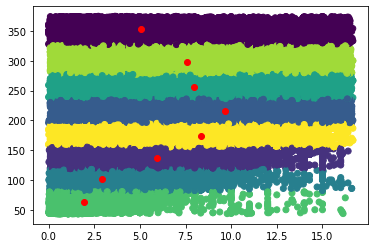

In [192]:
kmeans = KMeans(n_clusters=8).fit(df_1)
centres = kmeans.cluster_centers_
print(centres)

plt.scatter(df_1['fat_100g'], df_1['energy-kcal_100g'], c= kmeans.labels_.astype(float))
plt.scatter(centres[:, 1], centres[:, 0], c='red')
plt.show()

In [194]:
#With this Kmeans, we can find similar products in regards to their energy and the amount of fat they contain